How to run: <br> Simply run all the code blocks sequentially.

### **Misc**

In [ ]:
#link my Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install python_mnist

!pip install python_mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load MINST images

from mnist import MNIST
import jax.numpy as jnp
import numpy as np

mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, Y_train.shape)

(60000, 784) (60000,) (10000, 784) (10000,) (60000, 10)


### **SVM model**

In [ ]:
class mySVM():
  def __init__(self, kernel='linear', optimizer='pgd', debug=0, threshold=0.001, \
               lr=1.0, max_epochs=20, batch_size=2, C=1, order=3, gamma=1.0, I=0, J=1):
    self.kernel = kernel           # kernel type
    self.optimizer = optimizer     # which optimizer is used to solve quadratic programming
    self.lr = lr                   # max learning rate in PGD
    self.max_epochs = max_epochs   # max epochs in PGD
    self.batch_size = batch_size   # size of each subset in PGD
    self.debug = debug             # whether print debugging info
    self.threshold = threshold     # threshold to filter out support vectors 
    self.label = {-1:I, 1:J}       # holding the labels

    self.C = C                     # C for the soft-margin term
    self.order = order             # power order for polynomial kernel
    self.gamma = gamma             # gamma for Gaussian RBF kernel

  # Kernel Function
  # X[N,d]: training samples;  Y[M,d]: other training samples
  # return Q[N,N]: linear kernel matrix between X and Y
  def Kernel(self, X, Y):
    if (self.kernel == 'linear'):
      K = X @ Y.T
    elif (self.kernel == 'poly'):
      K = np.power(X @ Y.T +1, self.order)
    elif (self.kernel == 'rbf'): 
      d1 = np.sum(X*X, axis=1) 
      d2 = np.sum(Y*Y, axis=1)
      K = np.outer(d1, np.ones(Y.shape[0])) + np.outer(np.ones(X.shape[0]), d2) \
          - 2 * X @ Y.T
      K = np.exp(-self.gamma * K) 
      
    return K

  # construct matrix Q from any kernel function for dual SVM optimization 
  def QuadraticMatrix(self, X, y):
    Q = np.outer(y, y) * self.Kernel(X, X) 
    return Q

  # clipping function
  def clip(self, a, L, H):
    a_new = max(L, a)
    a_new = min(H, a_new)
    return a_new

  # use SMO to update 2 alphas in each iteration
  def SMO(self, Q, X, y):
    N = Q.shape[0]   # num of training samples
    alpha = np.zeros(N)
    epoch = 0
    while epoch < self.max_epochs:
      i = 0
      while i < N:
        if i == N - 1:
          j = 0
        else:
          j = i + 1

        #update alpha i and j (based on my attempt of assignment 2 question 3)
        i_new = (1 - y[i]*y[j] - 2*Q[i][j]*(y[i]*y[j]*alpha[i] + alpha[j]) + 2*Q[j][j]*(alpha[i] + y[i]*y[j]*alpha[j]))/(2*(Q[i][i] - 2*Q[i][j]*y[i]*y[j] + Q[j][j]))
        if y[i] != y[j]:
          i_new = self.clip(i_new, max(0, alpha[j] - alpha[i]), min(self.C, self.C + alpha[j] - alpha[i]))
        else:
          i_new = self.clip(i_new, max(0, alpha[j] + alpha[i] - self.C), min(self.C, alpha[j] + alpha[i]))

        j_new = y[i]*y[j]*alpha[i] + alpha[j] - y[i]*y[j]*i_new

        alpha[i] = i_new
        alpha[j] = j_new

        i += 1
      epoch += 1
    return alpha
  
  # use projected gradient descent to solve quadratic program 
  # refer to Algorithm 6.5 on page 127
  # Q[N,N]: quadratic matrix;  y[N]: training labels (+1 or -1)
  def PGD(self, Q, y):
    N = Q.shape[0]   # num of training samples
    alpha = np.zeros(N)
    prev_L = 0.0

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(N)  #randomly shuffle data indices
      for batch_start in range(0, N, self.batch_size):
        idx = indices[batch_start:batch_start + self.batch_size] # indices of the current subset
        alpha_s = alpha[idx]
        y_s = y[idx]

        grad_s = Q[idx,:] @ alpha - np.ones(idx.shape[0])
        proj_grad_s = grad_s - np.dot(y_s,grad_s)/np.dot(y_s, y_s)*y_s

        bound = np.zeros(idx.shape[0])
        bound[proj_grad_s < 0] = self.C 

        eta = np.min(np.abs(alpha_s-bound)/(np.abs(proj_grad_s)+0.001))

        alpha[idx] -= min(eta, self.lr) * proj_grad_s

      L = 0.5 * alpha.T @ Q @ alpha - np.sum(alpha) # objective function 
      if (L > prev_L): 
        if (self.debug>0):
          print(f'Early stopping at epoch={epoch}! ({L})')
        break
      
      if (self.debug>1):
        print(f'[PGD optimizer] epoch = {epoch}: L = {L:.5f}  (# of support vectors = {(alpha>self.threshold).sum()})')
        print(f'                 alpha: max={np.max(alpha)} min={np.min(alpha)} orthogonal constraint={np.dot(alpha,y):.2f}')

      prev_L = L

    return alpha

  # train SVM from training samples
  # X[N,d]: input features;  y[N]: output labels (+1 or -1)
  def fit(self, X, y):
    if(self.kernel != 'linear' and self.kernel != 'poly' and self.kernel != 'rbf'):
      print("Error: only linear/poly/rbf kernel is supported!")
      return

    Q = self.QuadraticMatrix(X, y)

    if self.optimizer == "smo":
      alpha = self.SMO(Q, X, y)
    elif self.optimizer == "pgd":
      alpha = self.PGD(Q, y)

    #save support vectors (pruning all data with alpha==0)
    self.X_SVs = X[alpha>self.threshold]
    self.y_SVs = y[alpha>self.threshold]
    self.alpha_SVs = alpha[alpha>self.threshold]

    if(self.kernel == 'linear'):
      self.w = (self.y_SVs * self.alpha_SVs) @ self.X_SVs

    # estimate b
    idx = np.nonzero(np.logical_and(self.alpha_SVs>self.threshold,self.alpha_SVs<self.C-self.threshold))
    if(len(idx) == 0):
      idx = np.nonzero(self.alpha_SVs>self.threshold)
    # refer to the formula on page 125 (above Figure 6.11) 
    b = self.y_SVs[idx] - (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, self.X_SVs[idx])
    self.b = np.median(b)
    
    return 

  # use SVM from prediction (returns a vector of +1 and -1)
  # X[N,d]: input features
  def predict(self, X):
    if(self.kernel != 'linear' and self.kernel != 'poly' and self.kernel != 'rbf'):
      print("Error: only linear/poly/rbf kernel is supported!")
      return

    if(self.kernel == 'linear'):
      y = X @ self.w + self.b 
    else:
      y = (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, X) + self.b 

    return np.sign(y)

  # prediction function I added (returns a vector of predicted labels)
  # used for calculating testing accuracy
  def predict_label(self, X):
    if(self.kernel != 'linear' and self.kernel != 'poly' and self.kernel != 'rbf'):
      print("Error: only linear/poly/rbf kernel is supported!")
      return

    if(self.kernel == 'linear'):
      y = X @ self.w + self.b 
    else:
      y = (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, X) + self.b 

    return np.vectorize(self.label.get)(np.sign(y))


### **Autoencoder model**

In [ ]:
# use numpy to implement fully-connected neural networks with mini-batch SGD 
import numpy as np

# ReLU activation function
def relu(x):
  return np.maximum(x, 0) 

      ###############################################################################################################################
      ################################################### MODIFIED CODE BELOW #######################################################
      ###############################################################################################################################

# Sigmoid activation function for reconstruction of x
def sigmoid(X):
  return 1 / (1 + np.exp(-X))

class myMLP1():
  def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',\
               loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,\
               init_range=1.0, annealing=1.0):
    self.optimizer = optimizer     # which optimizer is used to learn
    self.lr = lr                   # initial learning rate in SGD
    self.annealing = annealing     # annealing rate in SGD
    self.max_epochs = max_epochs   # max epochs in optimization 
    self.batch_size = batch_size   # mini-batch size in SGD
    self.debug = debug             # whether print debugging info
    self.activation=activation     # activation function 
    self.loss = loss               # the loss used for training objective 
    self.random_state=random_state # random state
    self.init_range=init_range     # range for initializing weights 

    self.struct = struct           # network structure: e.g. [100], [500, 200], 
                                   #                         [100,100,100]
 
  # initialize internal struct/variables for input/output 
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets 
  def initialization(self, X, Y):
    np.random.seed(self.random_state)

    input = X.shape[1]                # input dimension 
    self.layers = len(self.struct)    # number of hidden layers 
    self.W = [0]*(self.layers+1)      # list for all weight matrices
    self.b = [0]*(self.layers+1)      # list for all bias vectors 
    self.W_grad = [0]*(self.layers+1) # list for weight gradients
    self.b_grad = [0]*(self.layers+1) # list for bias gradients 

    # create weight matrices for all hidden layers 
    for l in range(self.layers):  
      output = self.struct[l]
      self.W[l] = 4.90*(np.random.rand(input, output)-0.5)*self.init_range/np.sqrt(output+input)
      self.b[l] = np.zeros(output)
      self.W_grad[l] = np.random.rand(input, output)
      self.b_grad[l] = np.zeros(output)
      input = output 

    # create weight matrix for output layer
    output = Y.shape[1]
    self.W[self.layers] = 4.90*(np.random.rand(input, output)-0.5)*self.init_range/np.sqrt(output+input)
    self.b[self.layers] = np.zeros(output)
    self.W_grad[self.layers] = np.random.rand(input, output)
    self.b_grad[self.layers] = np.zeros(output)


  # forward pass to compute outputs for a mini-batch X
  # if return_Z=True, also save all hidden activation 
  # (refer to the box on page 166)
  # input =>  X[B,d]: a batch of input vectors
  # if return_Z=False, return only y[B,K]
  # otherwise, return activations for all layers (including hidden layers) 
  def forward(self, X, return_Z=False):
    # list to save all hidden nodes' activation values 
    if (return_Z):
      Zs = [0] * (self.layers+2)
    else:
      Zs = [0]

    Z = X
    if(return_Z):
        Zs[0] = Z
    # forward pass from all hidden layers
    for l in range(self.layers): 
      Z = relu(Z @ self.W[l]  + self.b[l])
      if(return_Z):
        Zs[l+1] = Z

      ###############################################################################################################################
      ################################################### MODIFIED CODE BELOW #######################################################
      ###############################################################################################################################

    #forward pass for output layer
    l = self.layers
    y = sigmoid(Z @ self.W[l] + self.b[l])
    if (return_Z):
      Zs[l+1] = y
    else:
      Zs[0] = y
    
    return Zs

  # backward pass to compute gradients for a mini-batch of inputs X and targets Y
  # Zs: list of all hidden activation values (pre-computed by a forward pass)
  # return gradients of all weight matrices and bias vectors 
  # (refer to the box on page 188)
  def backward(self, X, Y, Zs):
 
      ###############################################################################################################################
      ################################################### MODIFIED CODE BELOW #######################################################
      ###############################################################################################################################

    # output layer
    l = len(Zs)-1
    e = 0.5*(Zs[l] - Y)  # error signals for output layer (changed by me)
    WG = np.einsum('bo,bi->bio', e, Zs[l-1])
    self.W_grad[l-1] = np.mean(WG,axis=0) 
    self.b_grad[l-1] = np.mean(e,axis=0)

    # backward for all hidden layers
    for l in range(self.layers,0,-1):
      e = ( e @ self.W[l].T ) * np.heaviside(Zs[l],0) 
      WG = np.einsum('bo,bi->bio', e, Zs[l-1])
      self.W_grad[l-1] = np.mean(WG,axis=0)
      self.b_grad[l-1] = np.mean(e,axis=0)

    return self.W_grad, self.b_grad

  # mini-batch SGD to update model parameters (Algorith 8.8 on page 189) 
  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets
  def sgd(self, X, Y):
    n = X.shape[0]            # number of samples

    lr = self.lr
    errorsA = np.zeros(self.max_epochs)
    errorsC = np.zeros(self.max_epochs)

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(n)  #randomly shuffle data indices
      for batch_start in range(0, n, self.batch_size):
        X_batch = X[indices[batch_start:batch_start + self.batch_size]]
        Y_batch = Y[indices[batch_start:batch_start + self.batch_size]]

        Zs = self.forward(X_batch, return_Z=True)

        W_grad, b_grad = self.backward(X_batch, Y_batch, Zs)

        for l in range(self.layers+1):
          self.W[l] -= lr * W_grad[l]
          self.b[l] -= lr * b_grad[l]

      ###############################################################################################################################
      ################################################### MODIFIED CODE BELOW #######################################################
      ###############################################################################################################################

      # plot all learning curves (A, B, C)
      Z = self.forward(X, return_Z=False)
      #calculate the mean squared error
      errorsC[epoch] = np.mean((Z[0]-Y)**2)

      train_label = np.argmax(Y, axis=1)
      train_res = np.argmax(Z[0], axis=1)
      errorsA[epoch] = np.count_nonzero(np.equal(train_res,train_label))/train_label.size

      if(self.debug):
        print(f'epoch = {epoch} (lr={lr:.2}): C = {errorsC[epoch]:.5f}')

      lr *= self.annealing

    return errorsA, errorsC

  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets          
  def fit(self, X, Y):

    self.initialization(X, Y)

    errorsA, errorsC = self.sgd(X, Y)

    return errorsA, errorsC

  # X[N,d]: input features;
  # return: labels (NOT one-hot)
  def predict(self, X):
    Y = self.forward(X,return_Z=False)
    #return np.argmax(Y[0], axis=1)
    return Y[0]

  # this function is used for returning the code layer i.e. the extracted features
  def predict_code(self, X):
    Y = self.forward(X,return_Z=True)
    mid_index = int(len(self.struct) / 2)
    return Y[mid_index]

### **Bottleneck feature extractor model**

In [ ]:
# use numpy to implement fully-connected neural networks with mini-batch SGD 
import numpy as np

# ReLU activation function
def relu(x):
  return np.maximum(x, 0) 

# column-wise softmax
# X[N,d]: softmax over d
def softmax(X):
  m = X.max(axis=1)
  return np.transpose(np.exp(X.T-m)/np.sum(np.exp(X.T-m), axis=0))

class myMLP2():
  def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',\
               loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,\
               init_range=1.0, annealing=1.0):
    self.optimizer = optimizer     # which optimizer is used to learn
    self.lr = lr                   # initial learning rate in SGD
    self.annealing = annealing     # annealing rate in SGD
    self.max_epochs = max_epochs   # max epochs in optimization 
    self.batch_size = batch_size   # mini-batch size in SGD
    self.debug = debug             # whether print debugging info
    self.activation=activation     # activation function 
    self.loss = loss               # the loss used for training objective 
    self.random_state=random_state # random state
    self.init_range=init_range     # range for initializing weights 

    self.struct = struct           # network structure: e.g. [100], [500, 200], 
                                   #                         [100,100,100]
 
  # initialize internal struct/variables for input/output 
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets 
  def initialization(self, X, Y):
    np.random.seed(self.random_state)

    input = X.shape[1]                # input dimension 
    self.layers = len(self.struct)    # number of hidden layers 
    self.W = [0]*(self.layers+1)      # list for all weight matrices
    self.b = [0]*(self.layers+1)      # list for all bias vectors 
    self.W_grad = [0]*(self.layers+1) # list for weight gradients
    self.b_grad = [0]*(self.layers+1) # list for bias gradients 

    # create weight matrices for all hidden layers 
    for l in range(self.layers):  
      output = self.struct[l]
      self.W[l] = 4.90*(np.random.rand(input, output)-0.5)*self.init_range/np.sqrt(output+input)
      self.b[l] = np.zeros(output)
      self.W_grad[l] = np.random.rand(input, output)
      self.b_grad[l] = np.zeros(output)
      input = output 

    # create weight matrix for output layer
    output = Y.shape[1]
    self.W[self.layers] = 4.90*(np.random.rand(input, output)-0.5)*self.init_range/np.sqrt(output+input)
    self.b[self.layers] = np.zeros(output)
    self.W_grad[self.layers] = np.random.rand(input, output)
    self.b_grad[self.layers] = np.zeros(output)


  # forward pass to compute outputs for a mini-batch X
  # if return_Z=True, also save all hidden activation 
  # (refer to the box on page 166)
  # input =>  X[B,d]: a batch of input vectors
  # if return_Z=False, return only y[B,K]
  # otherwise, return activations for all layers (including hidden layers) 
  def forward(self, X, return_Z=False):
    # list to save all hidden nodes' activation values 
    if (return_Z):
      Zs = [0] * (self.layers+2)
    else:
      Zs = [0]

    Z = X
    if(return_Z):
        Zs[0] = Z
    # forward pass from all hidden layers
    for l in range(self.layers): 
      Z = relu(Z @ self.W[l]  + self.b[l])
      if(return_Z):
        Zs[l+1] = Z

    #forward pass for output layer
    l = self.layers
    y = softmax(Z @ self.W[l] + self.b[l])
    if (return_Z):
      Zs[l+1] = y
    else:
      Zs[0] = y
    
    return Zs

  # backward pass to compute gradients for a mini-batch of inputs X and targets Y
  # Zs: list of all hidden activation values (pre-computed by a forward pass)
  # return gradients of all weight matrices and bias vectors 
  # (refer to the box on page 188)
  def backward(self, X, Y, Zs):
 
    # output layer
    l = len(Zs)-1
    e = Zs[l] - Y  # error signals for output layer 
    WG = np.einsum('bo,bi->bio', e, Zs[l-1])
    self.W_grad[l-1] = np.mean(WG,axis=0) 
    self.b_grad[l-1] = np.mean(e,axis=0)

    # backward for all hidden layers
    for l in range(self.layers,0,-1):
      e = ( e @ self.W[l].T ) * np.heaviside(Zs[l],0) 
      WG = np.einsum('bo,bi->bio', e, Zs[l-1])
      self.W_grad[l-1] = np.mean(WG,axis=0)
      self.b_grad[l-1] = np.mean(e,axis=0)

    return self.W_grad, self.b_grad

  # mini-batch SGD to update model parameters (Algorith 8.8 on page 189) 
  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets
  def sgd(self, X, Y):
    n = X.shape[0]            # number of samples

    lr = self.lr
    errorsA = np.zeros(self.max_epochs)
    errorsC = np.zeros(self.max_epochs)

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(n)  #randomly shuffle data indices
      for batch_start in range(0, n, self.batch_size):
        X_batch = X[indices[batch_start:batch_start + self.batch_size]]
        Y_batch = Y[indices[batch_start:batch_start + self.batch_size]]

        Zs = self.forward(X_batch, return_Z=True)

        W_grad, b_grad = self.backward(X_batch, Y_batch, Zs)

        for l in range(self.layers+1):
          self.W[l] -= lr * W_grad[l]
          self.b[l] -= lr * b_grad[l]

      # plot all learning curves (A, B, C)
      Z = self.forward(X, return_Z=False)
      errorsC[epoch] = -np.mean (np.log(Z[0][Y==1]))

      train_label = np.argmax(Y, axis=1)
      train_res = np.argmax(Z[0], axis=1)
      errorsA[epoch] = np.count_nonzero(np.equal(train_res,train_label))/train_label.size

      if(self.debug):
        print(f'epoch = {epoch} (lr={lr:.2}): C = {errorsC[epoch]:.5f}  A = {100*errorsA[epoch]:.2f}%')

      lr *= self.annealing

    return errorsA, errorsC

  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets          
  def fit(self, X, Y):

    self.initialization(X, Y)

    errorsA, errorsC = self.sgd(X, Y)

    return errorsA, errorsC

  # X[N,d]: input features;
  # return: labels (NOT one-hot)
  def predict(self, X):
    Y = self.forward(X,return_Z=False)
    return np.argmax(Y[0], axis=1)

  def predict_code(self, X):
    Y = self.forward(X,return_Z=True)
    mid_index = int(len(self.struct) / 2)
    return Y[mid_index]    

### Autoencoder **[50,20,50]** test accuracy=93.13%

epoch = 0 (lr=0.001): C = 0.03628
epoch = 1 (lr=0.0009): C = 0.02818
epoch = 2 (lr=0.00081): C = 0.02503
epoch = 3 (lr=0.00073): C = 0.02325
epoch = 4 (lr=0.00066): C = 0.02139
epoch = 5 (lr=0.00059): C = 0.02046
epoch = 6 (lr=0.00053): C = 0.01993
epoch = 7 (lr=0.00048): C = 0.01960
epoch = 8 (lr=0.00043): C = 0.01935
epoch = 9 (lr=0.00039): C = 0.01920
epoch = 10 (lr=0.00035): C = 0.01899
epoch = 11 (lr=0.00031): C = 0.01889
test MSE = 0.018478185957949634%


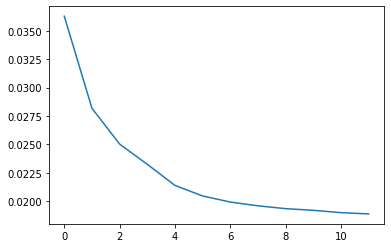

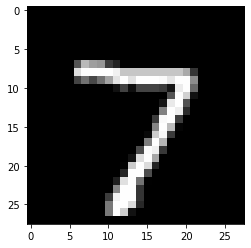

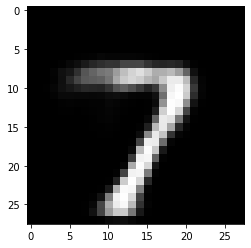

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP1(struct=[50,20,50], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.001)

A, C = mlp.fit(X_train, X_train) 

result = mlp.predict(X_test)
print(f'test MSE = {np.mean((result-X_test)**2)}%')

fig = plt.plot(C)
plt.show(fig)

plt.imshow(X_test[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(result[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=92.52%  test accuracy=93.13%


### Autoencoder **[100,50,100]** test accuracy=94.70%

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.001): C = 0.02630
epoch = 1 (lr=0.0009): C = 0.01734
epoch = 2 (lr=0.00081): C = 0.01446
epoch = 3 (lr=0.00073): C = 0.01257
epoch = 4 (lr=0.00066): C = 0.01187
epoch = 5 (lr=0.00059): C = 0.01080
epoch = 6 (lr=0.00053): C = 0.01018
epoch = 7 (lr=0.00048): C = 0.00966
epoch = 8 (lr=0.00043): C = 0.00935
epoch = 9 (lr=0.00039): C = 0.00907
epoch = 10 (lr=0.00035): C = 0.00892
epoch = 11 (lr=0.00031): C = 0.00858
test MSE = 0.008292736171176734%


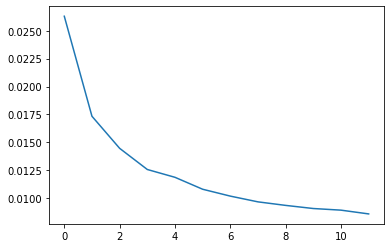

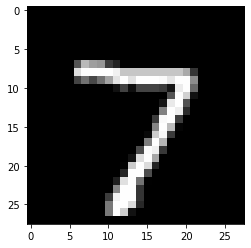

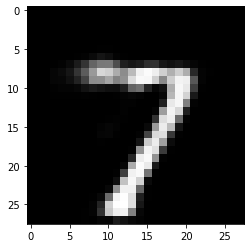

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP1(struct=[100,50,100], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.001)

A, C = mlp.fit(X_train, X_train) 

result = mlp.predict(X_test)
print(f'test MSE = {np.mean((result-X_test)**2)}%')

fig = plt.plot(C)
plt.show(fig)

plt.imshow(X_test[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(result[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=94.11%  test accuracy=94.70%


### Autoencoder **[150,100,50,100,150]** test accuracy=93.42%

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.001): C = 0.02935
epoch = 1 (lr=0.0009): C = 0.02057
epoch = 2 (lr=0.00081): C = 0.01664
epoch = 3 (lr=0.00073): C = 0.01442
epoch = 4 (lr=0.00066): C = 0.01307
epoch = 5 (lr=0.00059): C = 0.01230
epoch = 6 (lr=0.00053): C = 0.01146
epoch = 7 (lr=0.00048): C = 0.01097
epoch = 8 (lr=0.00043): C = 0.01071
epoch = 9 (lr=0.00039): C = 0.01026
epoch = 10 (lr=0.00035): C = 0.00989
epoch = 11 (lr=0.00031): C = 0.00981
test MSE = 0.00957943784484455%


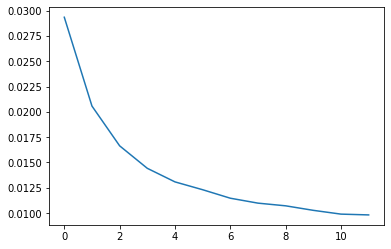

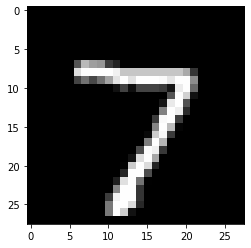

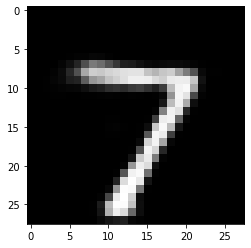

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP1(struct=[150,100,50,100,150], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.001)

A, C = mlp.fit(X_train, X_train) 

result = mlp.predict(X_test)
print(f'test MSE = {np.mean((result-X_test)**2)}%')

fig = plt.plot(C)
plt.show(fig)

plt.imshow(X_test[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(result[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=93.14%  test accuracy=93.42%


### Autoencoder **[150,125,100,50,100,125,150]** test accuracy=94.35%

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.001): C = 0.03617
epoch = 1 (lr=0.0009): C = 0.02542
epoch = 2 (lr=0.00081): C = 0.02159
epoch = 3 (lr=0.00073): C = 0.01941
epoch = 4 (lr=0.00066): C = 0.01598
epoch = 5 (lr=0.00059): C = 0.01477
epoch = 6 (lr=0.00053): C = 0.01386
epoch = 7 (lr=0.00048): C = 0.01309
epoch = 8 (lr=0.00043): C = 0.01256
epoch = 9 (lr=0.00039): C = 0.01192
epoch = 10 (lr=0.00035): C = 0.01163
epoch = 11 (lr=0.00031): C = 0.01124
test MSE = 0.01106892750506431%


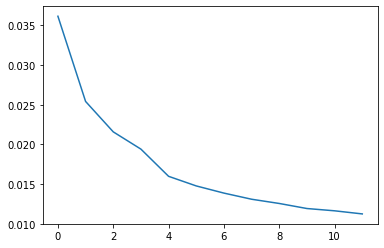

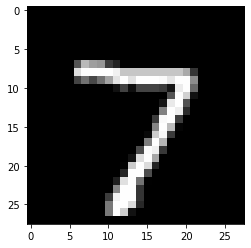

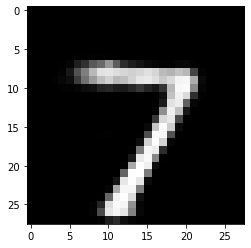

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP1(struct=[150,125,100,50,100,125,150], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.001)

A, C = mlp.fit(X_train, X_train) 

result = mlp.predict(X_test)
print(f'test MSE = {np.mean((result-X_test)**2)}%')

fig = plt.plot(C)
plt.show(fig)

plt.imshow(X_test[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(result[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=93.79%  test accuracy=94.35%


### Bottleneck feature extractor **[50,20,50]** test accuracy=95.97%

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.001): C = 0.83760  A = 78.30%
epoch = 1 (lr=0.0009): C = 0.46088  A = 86.98%
epoch = 2 (lr=0.00081): C = 0.37307  A = 89.22%
epoch = 3 (lr=0.00073): C = 0.33377  A = 90.41%
epoch = 4 (lr=0.00066): C = 0.31132  A = 91.04%
epoch = 5 (lr=0.00059): C = 0.29403  A = 91.57%
epoch = 6 (lr=0.00053): C = 0.28211  A = 91.84%
epoch = 7 (lr=0.00048): C = 0.27086  A = 92.18%
epoch = 8 (lr=0.00043): C = 0.26369  A = 92.39%
epoch = 9 (lr=0.00039): C = 0.25743  A = 92.58%
epoch = 10 (lr=0.00035): C = 0.25217  A = 92.68%
epoch = 11 (lr=0.00031): C = 0.24623  A = 92.88%
test accuracy = 93.04%


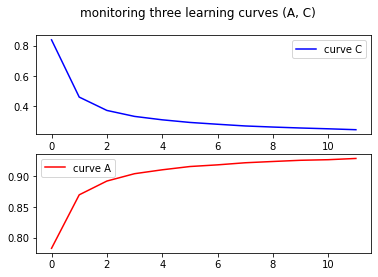

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP2(struct=[50,20,50], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.001)

A, C = mlp.fit(X_train, Y_train) 

result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=95.26%  test accuracy=95.97%


### Bottleneck feature extractor **[100,50,100]** test accuracy=95.83%

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.001): C = 0.57232  A = 84.11%
epoch = 1 (lr=0.0009): C = 0.38730  A = 89.17%
epoch = 2 (lr=0.00081): C = 0.33136  A = 90.61%
epoch = 3 (lr=0.00073): C = 0.29979  A = 91.40%
epoch = 4 (lr=0.00066): C = 0.27772  A = 92.00%
epoch = 5 (lr=0.00059): C = 0.26207  A = 92.43%
epoch = 6 (lr=0.00053): C = 0.25161  A = 92.73%
epoch = 7 (lr=0.00048): C = 0.24078  A = 93.07%
epoch = 8 (lr=0.00043): C = 0.23151  A = 93.36%
epoch = 9 (lr=0.00039): C = 0.22406  A = 93.58%
epoch = 10 (lr=0.00035): C = 0.21937  A = 93.74%
epoch = 11 (lr=0.00031): C = 0.21406  A = 93.88%
test accuracy = 93.76%


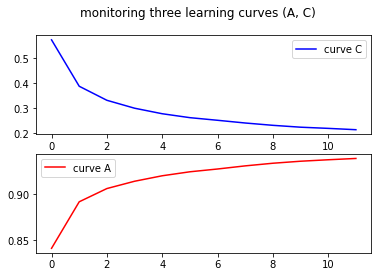

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP2(struct=[100,50,100], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.001)

A, C = mlp.fit(X_train, Y_train) 

result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=95.69%  test accuracy=95.83%


### Bottleneck feature extractor **[150,100,50,100,150]** test accuracy=96.47%

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.001): C = 0.58324  A = 83.42%
epoch = 1 (lr=0.0009): C = 0.37620  A = 89.12%
epoch = 2 (lr=0.00081): C = 0.30991  A = 91.15%
epoch = 3 (lr=0.00073): C = 0.27693  A = 91.96%
epoch = 4 (lr=0.00066): C = 0.24462  A = 92.95%
epoch = 5 (lr=0.00059): C = 0.22574  A = 93.44%
epoch = 6 (lr=0.00053): C = 0.20489  A = 94.08%
epoch = 7 (lr=0.00048): C = 0.19234  A = 94.39%
epoch = 8 (lr=0.00043): C = 0.18195  A = 94.77%
epoch = 9 (lr=0.00039): C = 0.17183  A = 95.00%
epoch = 10 (lr=0.00035): C = 0.16618  A = 95.19%
epoch = 11 (lr=0.00031): C = 0.16285  A = 95.23%
test accuracy = 94.99%


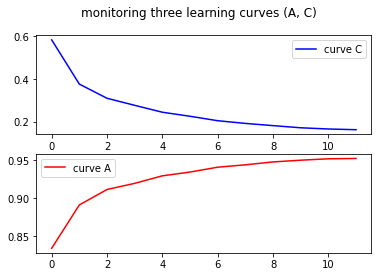

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP2(struct=[150,100,50,100,150], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.001)

A, C = mlp.fit(X_train, Y_train) 

result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=96.14%  test accuracy=96.47%


### Bottleneck feature extractor **[150,125,100,50,100,125,150]** test accuracy=96.56%

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.001): C = 1.15462  A = 66.44%
epoch = 1 (lr=0.0009): C = 0.41411  A = 87.62%
epoch = 2 (lr=0.00081): C = 0.30506  A = 90.96%
epoch = 3 (lr=0.00073): C = 0.25882  A = 92.18%
epoch = 4 (lr=0.00066): C = 0.22048  A = 93.61%
epoch = 5 (lr=0.00059): C = 0.20429  A = 93.97%
epoch = 6 (lr=0.00053): C = 0.18888  A = 94.40%
epoch = 7 (lr=0.00048): C = 0.17713  A = 94.83%
epoch = 8 (lr=0.00043): C = 0.16277  A = 95.31%
epoch = 9 (lr=0.00039): C = 0.15621  A = 95.52%
epoch = 10 (lr=0.00035): C = 0.14767  A = 95.70%
epoch = 11 (lr=0.00031): C = 0.13961  A = 95.94%
test accuracy = 95.37%


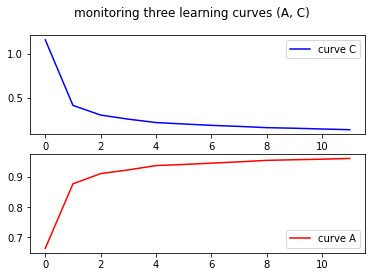

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP2(struct=[150,125,100,50,100,125,150], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.001)

A, C = mlp.fit(X_train, Y_train) 

result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=96.49%  test accuracy=96.56%


### Bottleneck feature extractor **[150,100,75,50,20,50,75,100,150]** test accuracy=97.79% lr=0.01 (7 vs. 9)

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.01): C = 0.18783  A = 94.79%
epoch = 1 (lr=0.009): C = 0.11786  A = 96.63%
epoch = 2 (lr=0.0081): C = 0.11139  A = 96.66%
epoch = 3 (lr=0.0073): C = 0.09872  A = 97.15%
epoch = 4 (lr=0.0066): C = 0.05103  A = 98.52%
epoch = 5 (lr=0.0059): C = 0.04428  A = 98.74%
epoch = 6 (lr=0.0053): C = 0.03771  A = 98.92%
epoch = 7 (lr=0.0048): C = 0.02371  A = 99.33%
epoch = 8 (lr=0.0043): C = 0.01856  A = 99.52%
epoch = 9 (lr=0.0039): C = 0.01672  A = 99.54%
epoch = 10 (lr=0.0035): C = 0.01084  A = 99.74%
epoch = 11 (lr=0.0031): C = 0.00845  A = 99.80%
test accuracy = 97.49%


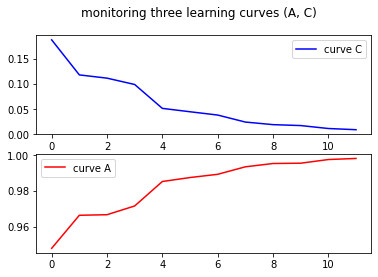

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP2(struct=[150,100,75,50,20,50,75,100,150], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.01)

A, C = mlp.fit(X_train, Y_train) 

result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '7' and '9' for binary SVMs

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=98.66%  test accuracy=97.79%


### Bottleneck feature extractor **[150,100,75,50,20,50,75,100,150]** test accuracy=99.33% lr=0.01 (0 vs. 8)

In [ ]:
mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

epoch = 0 (lr=0.01): C = 0.18783  A = 94.79%
epoch = 1 (lr=0.009): C = 0.11786  A = 96.63%
epoch = 2 (lr=0.0081): C = 0.11139  A = 96.66%
epoch = 3 (lr=0.0073): C = 0.09872  A = 97.15%
epoch = 4 (lr=0.0066): C = 0.05103  A = 98.52%
epoch = 5 (lr=0.0059): C = 0.04428  A = 98.74%
epoch = 6 (lr=0.0053): C = 0.03771  A = 98.92%
epoch = 7 (lr=0.0048): C = 0.02371  A = 99.33%
epoch = 8 (lr=0.0043): C = 0.01856  A = 99.52%
epoch = 9 (lr=0.0039): C = 0.01672  A = 99.54%
epoch = 10 (lr=0.0035): C = 0.01084  A = 99.74%
epoch = 11 (lr=0.0031): C = 0.00845  A = 99.80%
test accuracy = 97.49%


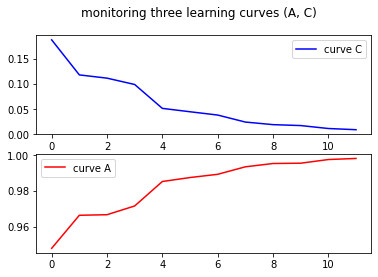

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP2(struct=[150,100,75,50,20,50,75,100,150], debug=1, max_epochs=12, annealing=0.9, batch_size=10, lr=0.01)

A, C = mlp.fit(X_train, Y_train) 

result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

In [ ]:
#prepare dataset with extracted features

train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = mlp.predict_code(train_data)/255.0
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = mlp.predict_code(test_data)/255.0
test_label = np.array(test_label, dtype='short')

In [ ]:
# prepare digits '0' and '8' for binary SVMs

digit_train_index = np.logical_or(train_label == 0, train_label == 8)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 0, test_label == 8)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '0' => -1, '8' => +1
CUTOFF = 4 # any number between '0' and '8'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

In [ ]:
c = 2
g = 9

svm = mySVM(max_epochs=20, optimizer='smo', C=c, kernel='rbf', gamma=g, debug=0, I=7, J=9)
svm.fit(X_train,y_train)

predict = svm.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = svm.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'MY RBF SVM (C={c}, gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')

MY RBF SVM (C=2, gamma=9): training accuracy=99.69%  test accuracy=99.33%
